<a href="https://colab.research.google.com/github/alracey/level4-project/blob/Higher-dimensions/piecewise_quadratic_2d_opt_bins_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#get Times New Roman
import matplotlib.font_manager as fm

!wget -O TimesNewRoman.ttf https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf
font_dirs = ["/content/"]
font_files = fm.findSystemFonts(fontpaths=font_dirs, fontext='ttf')
for font_file in font_files:
    print(font_file) if 'TimesNewRoman' in font_file else None
    fm.fontManager.addfont(font_file)

plt.rcParams['font.serif'] = "Times New Roman"
plt.rcParams['font.family'] = "serif"

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

torch.__version__

--2026-02-05 11:39:25--  https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf [following]
--2026-02-05 11:39:26--  https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 834452 (815K) [application/octet-stream]
Saving to: ‘TimesNewRoman.ttf’

TimesNewRoman.ttf   100%[===================>] 814.89K  --.-KB/s    in 0.1s    

2026-02-05 11:39:26 (7.23 MB/s) - ‘TimesNewRoman.ttf’ saved [834452/834452]

/content/

'2.9.0+cpu'

In [2]:
#set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

dtype = torch.float32

Using device: cpu


This section defines the target function f, the piecewise transform g, and the transformed function h.

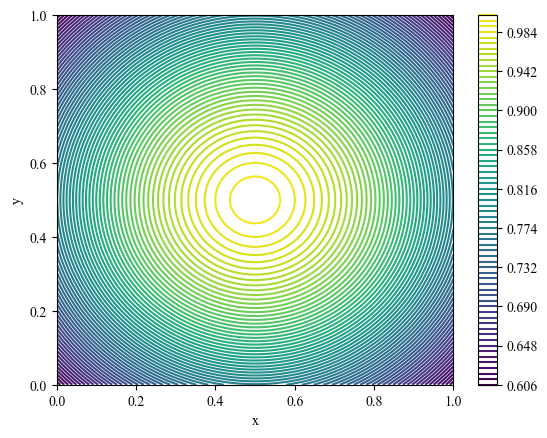

In [3]:
def f(x, y):
  return torch.exp(-((x-0.5)**2 + (y-0.5)**2))

def plot_f(N):
  xs, ys = torch.linspace(0, 1, N), torch.linspace(0, 1, N)
  X, Y = torch.meshgrid(xs, ys, indexing='xy')
  Z = f(X, Y)

  fig = plt.figure()
  plt.contour(X, Y, Z, levels=75, cmap='viridis')
  plt.colorbar()
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()
  return fig

test = plot_f(1000)


REMEMBER you have now changed the definition of params to include the endpoints, to allow testing with the identity transformation.

In [4]:
### Example parameters for testing ###

D, n, K = 2, 10, 8

x = torch.rand(D, n)
params = torch.tensor([0.5, 0.4, 0.5, 0.4, 0.5, 0.4, 0.5, 0.4, 0.5]).repeat(D, 1)
print(x)
print(params)

tensor([[0.2063, 0.5373, 0.3092, 0.0822, 0.8510, 0.7544, 0.3712, 0.7638, 0.5316,
         0.1479],
        [0.4269, 0.5089, 0.0749, 0.8732, 0.1416, 0.8689, 0.5961, 0.8631, 0.6399,
         0.5764]])
tensor([[0.5000, 0.4000, 0.5000, 0.4000, 0.5000, 0.4000, 0.5000, 0.4000, 0.5000],
        [0.5000, 0.4000, 0.5000, 0.4000, 0.5000, 0.4000, 0.5000, 0.4000, 0.5000]])


Debugging g

In [ ]:
### experimenting ###

'''Illustrative example for vectorised indexing'''
#row_indices = torch.arange(D).unsqueeze(1)
#i_values = torch.tensor([[2,1,3],
#                         [1,4,0]])
#v = torch.tensor([[0, 0.4, 1.2, 0.8, 1.0],
#                 [0, 0.3, 0.9, 0.7, 0.6]])
#print(v[row_indices, i_values])

x = torch.rand(D, n)
i_values = []
bins = torch.linspace(0, 1, K+1).repeat(2, 1)
for d in range(D):
  i_d = torch.bucketize(x[d], bins[d], right=False) - 1
  i_values.append(i_d.clamp(min=0, max=K-1))
i_values = torch.stack(i_values, dim=0)

row_indices = torch.arange(D).unsqueeze(1)
x_left = bins[row_indices, i_values]    #shape (D, n)
x_right = bins[row_indices, i_values+1]
w_b = x_right - x_left

v = params

#area calcs
v_left_for_areas = v[:, :-1]
v_right_for_areas = v[:, 1:]
bin_widths = bins[:, 1:] - bins[:, :-1]
bin_areas = 0.5 * (v_left_for_areas + v_right_for_areas) * bin_widths

#normalisation - enforce unit total area per dimension
total_area = bin_areas.sum(dim=1, keepdim=True)
v = v / total_area

# recompute bin areas with normalised PDF
v_left_for_areas = v[:, :-1]
v_right_for_areas = v[:, 1:]
new_bin_areas = 0.5 * (v_left_for_areas + v_right_for_areas) * bin_widths

#pdf heights
v_left = v[row_indices, i_values]
v_right = v[row_indices, i_values+1]
w_v = v_right - v_left    #slope of pdf inside bin (linear)

#cumulative area to left of x values
cum_areas = torch.zeros(D, n)
for d in range(D):
  for i in range(n):
    cum_areas[d, i] = torch.sum(new_bin_areas[d, :i_values[d, i]])


print('bins:', bins)
print('x values:', x)
print('i_values:', i_values)
#print('w_b:', w_b)
#print('w_v:', w_v)
print('v_left_for_areas:', v_left_for_areas)
print('v_right_for_areas:', v_right_for_areas)
print('bin widths:', bin_widths)
print('bin areas:', new_bin_areas)
print(torch.sum(new_bin_areas, dim=1))
print(cum_areas)

bins: tensor([[0.0000, 0.1250, 0.2500, 0.3750, 0.5000, 0.6250, 0.7500, 0.8750, 1.0000],
        [0.0000, 0.1250, 0.2500, 0.3750, 0.5000, 0.6250, 0.7500, 0.8750, 1.0000]])
x values: tensor([[0.9415, 0.1892, 0.2857, 0.4498, 0.4754, 0.1926, 0.2964, 0.6110, 0.5127,
         0.4472],
        [0.8919, 0.6207, 0.1063, 0.8829, 0.7159, 0.5662, 0.4243, 0.3584, 0.6982,
         0.6848]])
i_values: tensor([[7, 1, 2, 3, 3, 1, 2, 4, 4, 3],
        [7, 4, 0, 7, 5, 4, 3, 2, 5, 5]])
v_left_for_areas: tensor([[1.1111, 0.8889, 1.1111, 0.8889, 1.1111, 0.8889, 1.1111, 0.8889],
        [1.1111, 0.8889, 1.1111, 0.8889, 1.1111, 0.8889, 1.1111, 0.8889]])
v_right_for_areas: tensor([[0.8889, 1.1111, 0.8889, 1.1111, 0.8889, 1.1111, 0.8889, 1.1111],
        [0.8889, 1.1111, 0.8889, 1.1111, 0.8889, 1.1111, 0.8889, 1.1111]])
bin widths: tensor([[0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])
bin areas: tensor([[0.1250, 0.125

In [5]:
def preprocess_params_2(params, bins):
    """
    params: (D, K+1) unnormalised PDF heights
    returns:
      v:         (D, K+1) normalised PDF heights
      bin_areas: (D, K)   normalised bin areas
    """

    v = params
    v_left = v[:, :-1]
    v_right = v[:, 1:]
    bin_widths = bins[:, 1:] - bins[:, :-1]

    bin_areas = 0.5 * (v_left + v_right) * bin_widths
    total_area = bin_areas.sum(dim=1, keepdim=True)

    # normalise
    v = v / total_area
    bin_areas = bin_areas / total_area

    return v, bin_areas


Defining the piecewise quadratic transform g which returns the cumulative distribution function values for an input x corresponding to the given parameters.

In [6]:
def g(x, params, bins):

  '''
  PARAMS NOW INCLUDES ZEROS AND ONES TO SKIP CONCATENATING
  Piecewise quadratic transform with K bins, independent in different dimensions.
  This version does not yet predict (optimise) bin widths.
  x.shape = (D, n); params.shape = (D, K+1) where D is dimensions, K is number of bins
  "x ---> y"
  '''

  device = x.device
  dtype = x.dtype

  D, n = x.shape
  K = params.size(1) - 1

  #find indices
  i_values = []
  for d in range(D):
    i_d = torch.bucketize(x[d], bins[d], right=False) - 1
    i_values.append(i_d)

  i_values = torch.stack(i_values, dim=0)   # shape (D, n)
  i_values_right = torch.clamp(i_values + 1, max=K)   #avoid out of range indexing

  v, bin_areas = preprocess_params_2(params, bins)  #get normalised pdf heights and bin areas

  #create row indices
  row_indices = torch.arange(D, device=device).unsqueeze(1)    #shape (D, 1)

  #bin edges
  x_left = bins[row_indices, i_values]    #shape (D, n)
  x_right = bins[row_indices, i_values_right]
  w_b = x_right - x_left   #shape (D, n)

  #pdf heights
  v_left = v[row_indices, i_values]
  v_right = v[row_indices, i_values_right]
  w_v = v_right - v_left    #slope of pdf inside bin (linear)

  #transform to local coordinate alpha
  eps = torch.finfo(dtype).eps
  alpha = (x - x_left) / (w_b + eps)    #avoid instability

  #cumulative area to left of x values
  cum_areas = torch.zeros(D, n, device=device, dtype=dtype)
  for d in range(D):
    for i in range(n):
      cum_areas[d, i] = torch.sum(bin_areas[d, :i_values[d, i]])

  c_left = cum_areas

  #compute quadratic mappings
  result = c_left + ((alpha**2/2) * w_v * w_b) + (alpha * v_left * w_b)
  return result   #quadratic in alpha with shape (D, n)


In [55]:
def plot_g(params, bins, dim, display_bins):
  '''
  dimension = 0 or 1
  '''

  x_plot = torch.rand(D, 1000)
  x_plot = x_plot.sort(dim=1).values

  g_plot = g(x_plot, params, bins)

  fig, ax = plt.subplots()

  ax.plot(x_plot[dim].cpu(), g_plot[dim].cpu())

  if display_bins == True:
    for b in bins[dim][1:-1]:
      ax.axvline(b.item(), color="gray", alpha=0.6)

  ax.set_xlabel(f"$x_{dim+1}$", fontsize=14)
  ax.set_ylabel(f"$g(x_{dim+1})$", fontsize=14)

  ax.set_xlim(0.0, 1.0)
  ax.set_ylim(0.0, 1.0)

  ax.tick_params(axis="both", which="major", direction="in", length=5, labelsize=10)
  ax.tick_params(axis="both", which="minor", direction="in", length=3)
  ax.minorticks_on()

  plt.show()

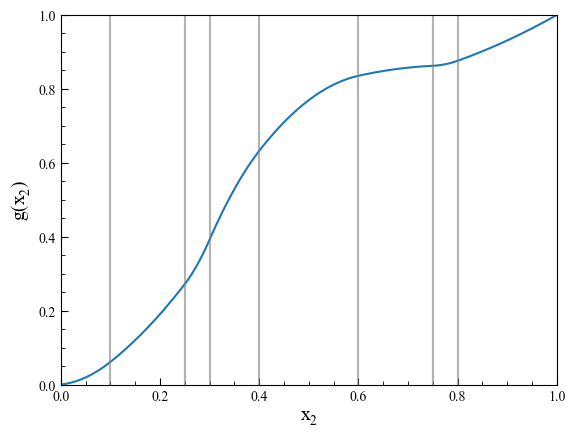

In [57]:
test_params = torch.rand(D, 9)
test_bins = torch.tensor([0, 0.1, 0.25, 0.3, 0.4, 0.6, 0.75, 0.8, 1]).repeat(D, 1)

plot_g(test_params, test_bins, dim=1, display_bins=True)

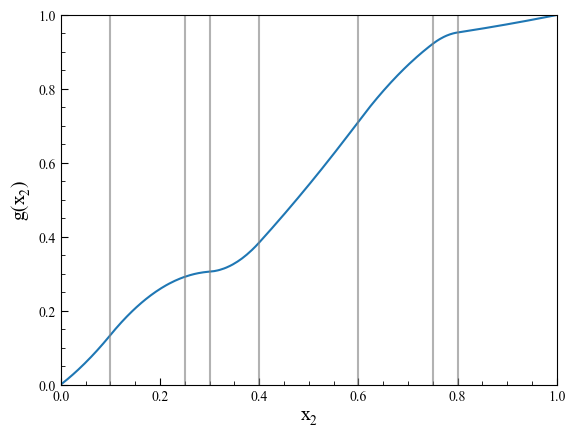

tensor(0.0005)
tensor(0.9998)


In [24]:
#test to check behaviour in one dimension at a time

K=8
x_test = torch.rand(D, 1000)
x_test = x_test.sort(dim=1).values

test_params = torch.rand(D, 9, device=device)
test_bins = torch.tensor([0, 0.1, 0.25, 0.3, 0.4, 0.6, 0.75, 0.8, 1]).repeat(D, 1)

g_test = g(x_test, test_params, test_bins)

fig, ax = plt.subplots()
ax.plot(x_test.squeeze()[1], g_test.squeeze()[1])   #data

for b in test_bins.squeeze()[1][1:-1]:
  ax.axvline(b.item(), color="gray", alpha=0.6)   #bin edges


ax.set_xlabel("$x_2$", fontsize=14)
ax.set_ylabel("$g(x_2)$", fontsize=14)

ax.tick_params(axis="both", which="major", direction="in", length=5, labelsize=10)
ax.tick_params(axis="both", which="minor", direction="in", length=3)
ax.minorticks_on()

ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
plt.show()


print(g_test.squeeze()[1][0])
print(g_test.squeeze()[1][-1])

Debugging h (for reference if required)

In [ ]:
### experimenting with h ###

cdf_values = test_g
v, bin_areas = preprocess_params(test_params)

#bins
bins = torch.linspace(0, 1, K+1).repeat(D, 1)


#v_left_for_areas = v[:, :-1]
#v_right_for_areas = v[:, 1:]
#bin_widths = bins[:, 1:] - bins[:, :-1]
#bin_areas = 0.5 * (v_left_for_areas + v_right_for_areas) * bin_widths #trapezium rule
c_edges = torch.zeros((D, K+1))   #cdf starts at 0
c_edges[:, 1:] = torch.cumsum(bin_areas, dim=1)

j_values = []
for d in range(D):
  j_d = torch.bucketize(cdf_values[d], c_edges[d], right=False) - 1
  j_values.append(j_d.clamp(min=0, max=K-1))

j_values = torch.stack(j_values, dim=0)   #these are correct so far

row_indices = torch.arange(D).unsqueeze(1)

#compute the edge positions
x_left = bins[row_indices, j_values]
x_right = bins[row_indices, j_values+1]
w_b = x_right - x_left    #bin width(s)

c_left = c_edges[row_indices, j_values]

v_left = v[row_indices, j_values]
v_right = v[row_indices, j_values+1]
w_v = v_right - v_left    #vertex differences

#solve quadratic to obtain alpha values

a = 0.5*w_v*w_b
b = v_left*w_b
c = c_left - cdf_values
disc = torch.clamp(b*b- 4*a*c, min=0)
alpha_plus = (-b + torch.sqrt(disc)) / (2*a)

#obtain x values

x = x_left + (w_b*alpha_plus)
jac = 1 / (v_left + w_v * alpha_plus)
jac_det = jac.prod(dim=0)

print('cdf_values:', cdf_values)
print('c_edges:', c_edges)
print('j_values:', j_values)
print('w_b:', w_b)
print('w_v:', w_v)
print('x:', x)
print('v_left:', v_left)
print('alphas:', alpha_plus)
print('Jacobians:', jac)
print('det(Jacobians):', jac_det)
print('h:', f(*x) * jac_det)

NameError: name 'test_g' is not defined

This section defines the transformed function h using the change of variables formula to preserve the integral value.

In [13]:
def h(y, params, bins):

  '''
  Resulting function when the piecewise warp is applied, in accordance with change of variables formula.
  Integral should be preserved.
  '''

  device = y.device
  dtype = y.dtype

  D, n = y.shape
  K = params.size(1) -1

  v, bin_areas = preprocess_params_2(params, bins)

  #cumulative areas

  c_edges = torch.zeros((D, K+1), device=device, dtype=dtype)   #cdf starts at 0
  c_edges[:, 1:] = torch.cumsum(bin_areas, dim=1)

  #find indices
  j_values = []
  for d in range(D):
    j_d = torch.bucketize(y[d], c_edges[d], right=False) - 1
    j_values.append(j_d)

  j_values = torch.stack(j_values, dim=0)
  j_values_right = torch.clamp(j_values + 1, max=K)   #avoid out of bounds indexing

  row_indices = torch.arange(D, device=device).unsqueeze(1)

  #compute the edge positions
  x_left = bins[row_indices, j_values]
  x_right = bins[row_indices, j_values_right]
  w_b = x_right - x_left    #bin width(s)

  c_left = c_edges[row_indices, j_values]

  v_left = v[row_indices, j_values]
  v_right = v[row_indices, j_values_right]
  w_v = v_right - v_left    #vertex differences

  #solve quadratic to obtain alpha values

  # coefficients
  a = 0.5 * w_v * w_b
  b = v_left * w_b
  c = c_left - y

  # linear vs quadratic bins
  eps = torch.finfo(dtype).eps
  is_linear = torch.abs(w_v) < eps

  alpha = torch.empty_like(y, device=device, dtype=dtype)

  # linear case
  alpha[is_linear] = (y[is_linear] - c_left[is_linear]) / (v_left[is_linear] * w_b[is_linear])

  # quadratic case
  disc = torch.clamp(b*b - 4*a*c, min=0.0)
  alpha[~is_linear] = (-b[~is_linear] + torch.sqrt(disc[~is_linear])) / (2*a[~is_linear])

  #jacobians

  jac = 1 / (v_left + (w_v*alpha))
  jac_det = jac.prod(dim=0)

  #obtain x values
  x = x_left + (w_b*alpha)

  return f(*x) * jac_det


Checking integral preservation and variance

In [16]:
#check integral is preserved using (naive) MC

###REFERENCE VALUE: 0.851121###
N = 1000000
#torch.manual_seed(42)
test_params = torch.rand(D, K+1)


def MC_F(N):
  x, y = torch.rand(N), torch.rand(N)
  f_evals = f(x, y)
  F_est = torch.mean(f_evals)
  alpha_F = torch.std(f_evals) / torch.sqrt(torch.tensor(N))
  return F_est, alpha_F

def MC_H(N, params, bins):
  y = torch.rand(D, N)
  h_evals = h(y, params, bins)
  H_est = torch.mean(h_evals)
  alpha_H = torch.std(h_evals) / torch.sqrt(torch.tensor(N))
  return H_est, alpha_H

F_est, alpha_F = MC_F(N)
print(f'F estimate = {F_est} ± {alpha_F}')

H_est, alpha_H = MC_H(N, test_params, test_bins)
print(f'H estimate = {H_est} ± {alpha_H}')

F estimate = 0.8509729504585266 ± 8.770232670940459e-05
H estimate = 0.8497097492218018 ± 0.0007691925275139511


In [17]:
#check that variances are different in general
test_vals = torch.rand(D, N)

f_var = torch.var(f(*test_vals))

h_for_var = h(test_vals, test_params, test_bins)
h_var = torch.var(h_for_var)

print("F variance:", f_var)
print("H variance:", h_var)

F variance: tensor(0.0077)
H variance: tensor(0.5940)


Defining the training loop for optimisation of parameters in order to minimise variance

In [20]:
#define a function which enforces positivity and enables use of unconstrained parameters inside training loop

def positive_params(params):
  eps = torch.finfo(params.dtype).eps
  return torch.nn.functional.softplus(params) + eps

#softmax so that the bin widths sum to 1

def softmax(params):
  return torch.nn.functional.softmax(params, dim=1)

def widths_to_edges(widths):    #assumes widths sum to 1

  int_edges = torch.cumsum(widths, dim=1)
  edges = torch.cat([int_edges.new_zeros((D, 1)), int_edges], dim=1)
  return edges

example_widths = torch.tensor([0.2, 0.1, 0.2, 0.3, 0.2]).repeat(D, 1)
print(widths_to_edges(example_widths))

tensor([[0.0000, 0.2000, 0.3000, 0.5000, 0.8000, 1.0000],
        [0.0000, 0.2000, 0.3000, 0.5000, 0.8000, 1.0000]])


In [26]:
from typing_extensions import final
#optimisation via training loop - loss function is the variance

def train_loop_improved(x, K, epochs, lr, device, ticker, early_stopping):
  '''
  x.shape = (D, n); K bins, D dimensions
  Early stopping parameters may be changed
  '''

  if device is None:
    device = x.device

  x = x.to(device=device, dtype=dtype)    #float64 precision can be added here
  D = x.size(0)

  #pdf heights
  heights = torch.rand((D, K+1), device=device, dtype=dtype, requires_grad=True)

  #bin widths
  raw_widths = torch.rand((D, K), device=device, dtype=dtype, requires_grad=True)

  #optimiser
  optimiser = torch.optim.Adam([
      {"params": heights, "lr": lr},
      {"params": raw_widths, "lr": lr * 0.25}   #decoupled learning rates
      ])

  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)
  loss_values = torch.zeros(epochs, device=device)

  # early stopping parameters
  tol = 1e-5          # tighter tolerance for float64
  patience = 4        #number of consecutive small changes allowed
  eps = 1e-10
  prev_loss = None
  small_change_count = 0
  grad_tol = 1e-5

  for epoch in range(epochs):
    params = positive_params(heights)
    widths = softmax(raw_widths)
    bins = widths_to_edges(widths)

    g_eval = g(x, params, bins)
    h_eval = h(g_eval, params, bins)

    loss = torch.var(h_eval)
    loss_values[epoch] = loss.detach()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    before_lr = optimiser.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimiser.param_groups[0]["lr"]

    if ticker and epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.8e}")

    # convergence-based early stopping
    if early_stopping == True:

      loss_val = loss.item()
      if prev_loss is not None:
          frac_change = abs(loss_val - prev_loss) / max(abs(prev_loss), eps)

          if frac_change < tol:
            small_change_count += 1
          else:
            small_change_count = 0

          if small_change_count >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

          prev_loss = loss_val

  final_loss = loss.detach()
  final_params = positive_params(heights).detach()
  final_widths = softmax(raw_widths).detach()

  return final_loss, loss_values[:epoch+1], final_params, final_widths


In [31]:
#test

train_x = torch.rand(D, 1000, device='cpu')
final_loss, loss_values, opt_params, opt_widths = train_loop_improved(train_x, K=10, epochs=300, lr=0.03, device=device, ticker=True, early_stopping=False)

opt_bins = widths_to_edges(opt_widths)

print("Final loss:", final_loss.item())
print("Optimised parameters:", opt_params)
print("Optimised bin edges:", opt_bins)

Epoch: 0 | Loss: 5.12069166e-02
Epoch: 10 | Loss: 3.83891561e-03
Epoch: 20 | Loss: 1.40000822e-03
Epoch: 30 | Loss: 9.17942554e-04
Epoch: 40 | Loss: 2.00607159e-04
Epoch: 50 | Loss: 7.43100027e-05
Epoch: 60 | Loss: 3.42126987e-05
Epoch: 70 | Loss: 1.01921369e-05
Epoch: 80 | Loss: 4.27428495e-06
Epoch: 90 | Loss: 2.66832149e-06
Epoch: 100 | Loss: 2.00729869e-06
Epoch: 110 | Loss: 1.69360817e-06
Epoch: 120 | Loss: 1.56320414e-06
Epoch: 130 | Loss: 1.53585870e-06
Epoch: 140 | Loss: 1.53295844e-06
Epoch: 150 | Loss: 1.52823350e-06
Epoch: 160 | Loss: 1.52535972e-06
Epoch: 170 | Loss: 1.52440873e-06
Epoch: 180 | Loss: 1.52399514e-06
Epoch: 190 | Loss: 1.52364873e-06
Epoch: 200 | Loss: 1.52334019e-06
Epoch: 210 | Loss: 1.52307109e-06
Epoch: 220 | Loss: 1.52280609e-06
Epoch: 230 | Loss: 1.52258247e-06
Epoch: 240 | Loss: 1.52236862e-06
Epoch: 250 | Loss: 1.52217444e-06
Epoch: 260 | Loss: 1.52199095e-06
Epoch: 270 | Loss: 1.52183395e-06
Epoch: 280 | Loss: 1.52167217e-06
Epoch: 290 | Loss: 1.5215

Visualisation of h with optimised parameters

In [28]:
#h plotter for 2d only

def h_plot(params, bins, N, levels):
  ys = torch.rand(N)
  ys = torch.sort(ys).values
  Y1, Y2 = torch.meshgrid(ys, ys, indexing='ij')
  points = torch.stack([Y1.flatten(), Y2.flatten()], dim=0)

  h_eval = h(points, params, bins)

  Z = h_eval.view(N, N).cpu()

  fig, ax = plt.subplots(figsize=(8,6))

  contour_plot = ax.contour(Y1.cpu(), Y2.cpu(), Z, levels=levels, cmap='viridis')

  ax.set_xlabel("$y_1$", fontsize=14)
  ax.set_ylabel("$y_2$", fontsize=14)

  ax.tick_params(axis="both", which="major", direction="out", length=5, labelsize=10)
  ax.tick_params(axis="both", which="minor", direction="out", length=3)
  ax.minorticks_on()

  ##legend decimal places##
  cbar = plt.colorbar(contour_plot, ax=ax)
  cbar.formatter = ticker.FormatStrFormatter('%.4f')
  cbar.update_ticks()

  ax.set_xlim(0.0, 1.0)
  ax.set_ylim(0.0, 1.0)

  plt.show()


def h_plot_colormesh(params, bins, N, shading):
  y1, y2 = torch.rand(N), torch.rand(N)
  y1_sorted, y2_sorted = torch.sort(y1).values, torch.sort(y2).values

  Y1, Y2 = torch.meshgrid(y1_sorted, y2_sorted, indexing='ij')

  points = torch.stack([Y1.flatten(), Y2.flatten()], dim=0)

  h_eval = h(points, params, bins)

  Z = h_eval.view(N, N).cpu()

  fig, ax = plt.subplots(figsize=(8,6))

  pcm = plt.pcolormesh(
    Y1,
    Y2,
    Z,
    cmap='viridis',
    shading='auto'
  )

  ax.set_xlabel("$y_1$", fontsize=14)
  ax.set_ylabel("$y_2$", fontsize=14)

  ax.tick_params(axis="both", which="major", direction="out", length=5, labelsize=10)
  ax.tick_params(axis="both", which="minor", direction="out", length=3)
  ax.minorticks_on()

  cbar = plt.colorbar(pcm, ax=ax)
  cbar.formatter = ticker.FormatStrFormatter('%.4f')
  cbar.update_ticks()

  ax.set_xlim(0.0, 1.0)
  ax.set_ylim(0.0, 1.0)

  plt.show()

Optimised parameters: tensor([[0.8151, 0.8790, 0.9821, 1.0244, 1.0456, 1.0488, 1.0290, 0.9953, 0.9481,
         0.8946, 0.8163],
        [0.8149, 0.8922, 0.9476, 0.9967, 1.0372, 1.0450, 1.0421, 0.9984, 0.9292,
         0.8838, 0.8148]])
Optimised bin edges: tensor([[0.0000, 0.0783, 0.2411, 0.3466, 0.4494, 0.5134, 0.6401, 0.7271, 0.8170,
         0.8975, 1.0000],
        [0.0000, 0.1011, 0.1861, 0.2774, 0.4030, 0.4690, 0.5761, 0.7203, 0.8448,
         0.9100, 1.0000]])


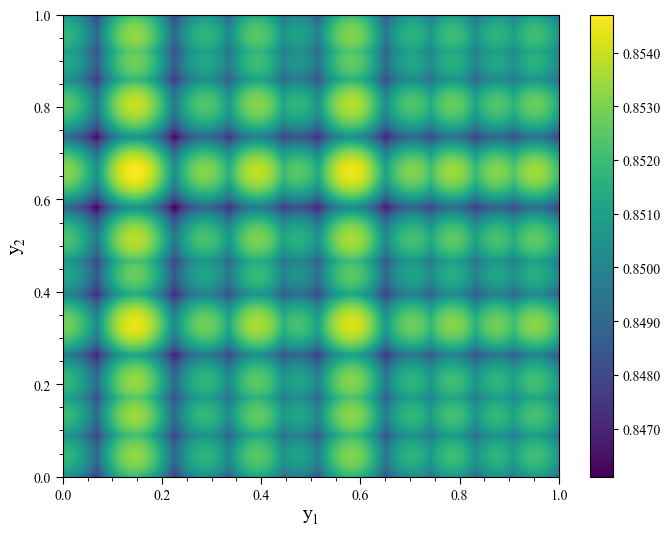

In [33]:
#plotting

print("Optimised parameters:", opt_params)
print("Optimised bin edges:", opt_bins)

h_plot_colormesh(opt_params.cpu(), opt_bins.cpu(), N=2500, shading='auto')

In [40]:
#plot a 1D slice of the 2D version to check behaviour
def h_slice_1d(params, bins, N, y2_fixed):
    """
    Plot a 1D slice of h(y_1, y_2) with y_2 fixed.
    """
    y1 = torch.rand(N, device=params.device)
    y1 = torch.sort(y1).values
    y2 = torch.full_like(y1, y2_fixed, device=params.device)

    y = torch.stack([y1, y2], dim=0)

    h_vals = h(y, params, bins)

    fig, ax = plt.subplots()
    ax.plot(y1.cpu(), h_vals.cpu())

    ax.set_xlabel('$y_1$', fontsize=14)
    ax.set_ylabel('$h(y_1, y_2)$', fontsize=14)

    ax.tick_params(axis="both", which="major", direction="in", length=5, labelsize=10)
    ax.tick_params(axis="both", which="minor", direction="in", length=3)
    ax.minorticks_on()

    ax.set_xlim(0.0, 1.0)

    plt.show()


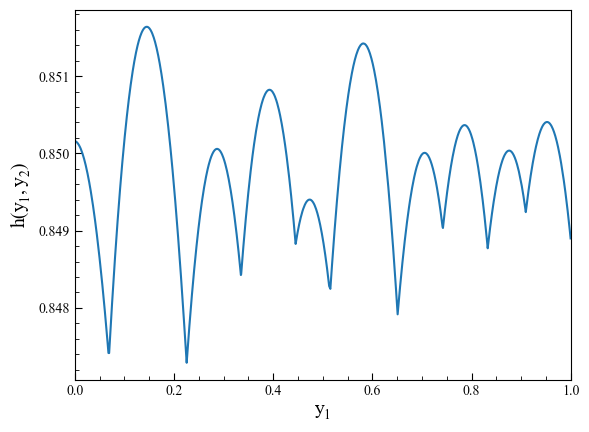

In [58]:
h_slice_1d(opt_params, opt_bins, N=2500, y2_fixed=0.4)

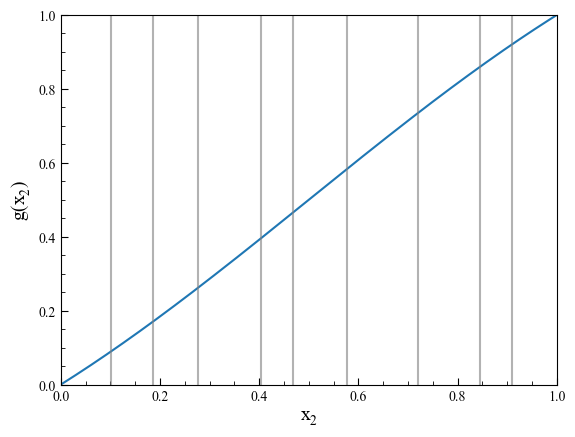

In [62]:
#plot of g with optimal parameters

plot_g(opt_params, opt_bins, dim=1, display_bins=True)

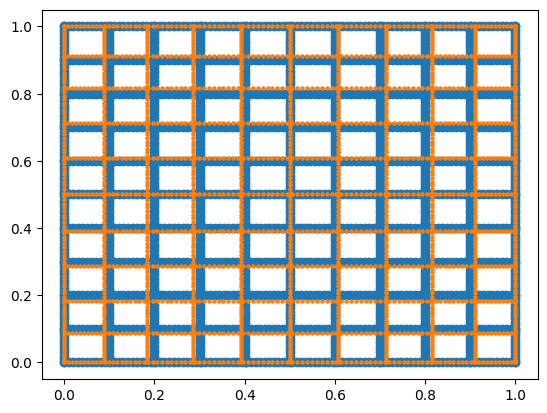

In [ ]:
#visualising behaviour of coordinates (for debugging purposes)
grid_params = torch.tensor([[0.2, 0.1, 0.2, 0.1, 0.2, 0.1, 0.2, 0.1, 0.2],
                            [0.1, 0.2, 0.1, 0.2, 0.1, 0.2, 0.1, 0.2, 0.1]])   #use torch.ones if checking nothing happens for identity transform

npts = 100
grid = torch.empty(22*npts,2)

for vi in range(11):
  beg = vi*npts
  end = beg+npts
  grid[beg:end,0] = vi/10
  grid[beg:end,1] = torch.linspace(0, 1, npts)

for hi in range(11):
  beg = (11+hi)*npts
  end = beg+npts
  grid[beg:end,1] = hi/10
  grid[beg:end,0] = torch.linspace(0, 1, npts)

#evaluate g on this grid

g_eval = g(grid.T, opt_params)
h_eval = h(grid.T, opt_params)
#max_error = torch.max(torch.abs(g_eval - grid.T))    only for checking nothing happens if no transformation is intended
#print(max_error)

plt.scatter(grid[:,0], grid[:,1])
plt.scatter(h_eval[0,:], h_eval[1,:], s=5)
plt.show()

Analysis

Loss vs epoch for different K

In [ ]:
#generate data

device = train_x.device
dtype = train_x.dtype

K_s = [2, 4, 8, 16, 32, 64]
epochs = 200
loss_values = torch.zeros((len(K_s), epochs), device=device, dtype=dtype)

print(train_x.device)
print(loss_values.device)

for i in range(len(K_s)):
  _, loss_hist, _ = train_loop(train_x, K_s[i], epochs, lr=0.03, device=None, ticker=False)
  loss_values[i] = loss_hist

cpu
cpu


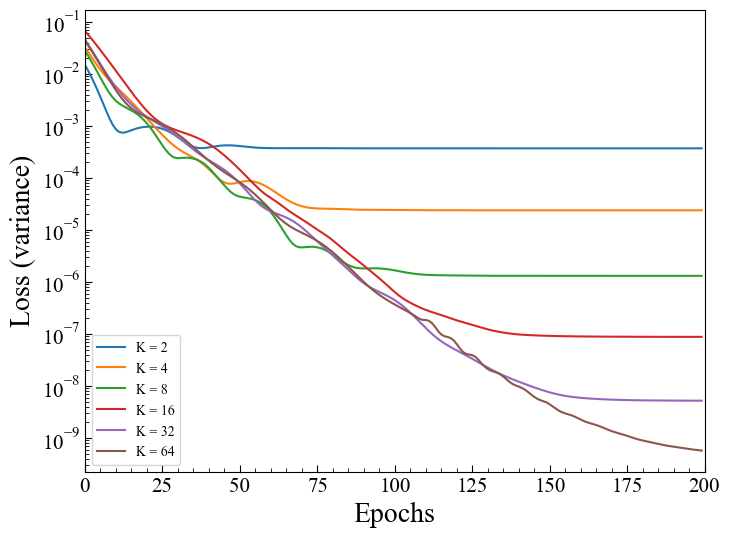

In [ ]:
#plotting

fig, ax = plt.subplots(figsize=(8,6))

epochs_plot = torch.arange(epochs)
for i in range(len(K_s)):
  ax.plot(epochs_plot, loss_values[i].detach().numpy(), label=f'K = {K_s[i]}')

ax.set_xlabel("Epochs", fontsize=20)
ax.set_ylabel("Loss (variance)", fontsize=20)

ax.tick_params(axis="both", which="major", direction="in", length=5, labelsize=15)
ax.tick_params(axis="both", which="minor", direction="in", length=3)
ax.minorticks_on()

ax.set_xlim(0, 200)

plt.legend(loc='lower left')
plt.yscale('log')
plt.show()

Loss vs K

In [ ]:
#generate data

Ks = range(2, 65)
vars = torch.zeros(len(Ks), device=device)

for i, K in enumerate(Ks):
    if K <= 30:
        epochs = 180
    elif K <= 45:
        epochs = 210
    else:
        epochs = 240

    result = train_loop(train_x, K, epochs=epochs, lr=0.03, device=None, ticker=False)[0]
    vars[i] = result.reshape(1)


In [ ]:
save_path = "/content/drive/MyDrive/vars.pt"
torch.save(vars, save_path)

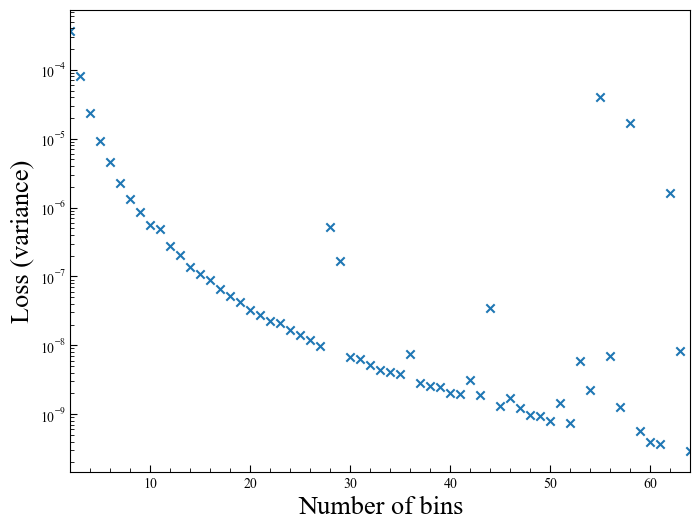

tensor([3.7068e-04, 7.9926e-05, 2.3843e-05], grad_fn=<SliceBackward0>)
tensor(2.9645e-10, grad_fn=<SelectBackward0>)


In [ ]:
#plotting

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(Ks, vars.detach().cpu().numpy(), marker='x')  # Detach and convert to numpy for plotting

ax.set_xlabel("Number of bins", fontsize=19)
ax.set_ylabel("Loss (variance)", fontsize=19)

ax.tick_params(axis="both", which="major", direction="in", length=5, labelsize=10)
ax.tick_params(axis="both", which="minor", direction="in", length=3)
ax.minorticks_on()

ax.set_xlim(2, 64)
plt.yscale('log')
plt.show()
print(vars[0:3])    #check for errors
print(vars[-1])     #check accuracy

Loss vs epoch for different learning rates

In [ ]:
#generate data

K = 16
l_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5]
epochs=200
loss_values = torch.zeros((len(l_rates), epochs), device=device)

for i in range(len(l_rates)):
  loss_values[i] = train_loop(train_x, K, epochs, lr=l_rates[i])[1]

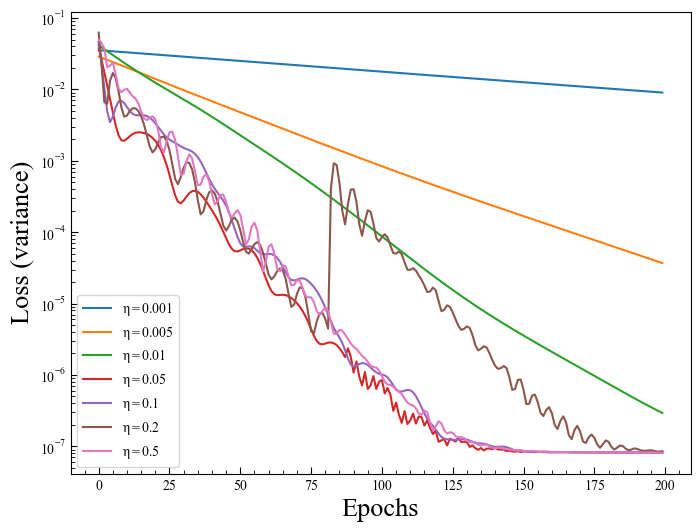

In [ ]:
#plotting

fig, ax = plt.subplots(figsize=(8, 6))

epochs_plot = torch.arange(epochs, device='cpu')
for i in range(len(l_rates)):
  ax.plot(epochs_plot, loss_values[i].detach().cpu().numpy(), label=rf"$\eta = {l_rates[i]}$")

ax.set_xlabel("Epochs", fontsize=19)
ax.set_ylabel("Loss (variance)", fontsize=19)

ax.tick_params(axis="both", which="major", direction="in", length=5, labelsize=10)
ax.tick_params(axis="both", which="minor", direction="in", length=3)
ax.minorticks_on()

#ax.set_xlim(0, 150)

plt.legend()
plt.yscale('log')
plt.show()